In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

from decimal import Decimal

import mesa_helper as mh
import os
import shutil
import copy
import time
import warnings

from scipy import ndimage, interpolate, optimize
from scipy.integrate import quad
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def read_MESAtable(filename):
    """
    read in a MESA table into an array of shape (nQ, nT, 19) = (349,121,19)
    array[:,:,-2] will be log10Q
    array[:,:,-1] will be log10rho

    Independent variables are T and Q, where logQ = logRho - 2logT + 12 (rho in [g cm^-3])
    """

    with open(filename) as f:
        for line in f:
            if len(line.split()) == 11:
                nQ = int(line.split()[7])
                nT = int(line.split()[3])

    tableData = np.zeros((349,121,19))

    iQ = -1
    iT = 0
    
    with open(filename) as f:
        for line in f:
            if len(line.split()) == 1:
                iQ += 1
                log10Q = float(line.split()[0])
                        
            if len(line.split()) == 17 and line.split()[0]!='logT':
                lineList = [float(lineEntry) for lineEntry in line.split()]
                lineArr  = np.array(lineList)

                tableData[iQ,iT,:-2] = lineArr
                tableData[iQ,iT,-2] = log10Q
                tableData[iQ,iT,-1] = log10Q + 2*lineArr[0] - 12
                
                iT += 1
                if iT >= nT:
                    iT = 0


    return tableData
            

In [3]:
ls ./my_MESAformat_tables/

mesa-h2o_100z00x.data          mesa-planetblend_30z20x.data
mesa-iron_100z00x.data         mesa-planetblend_30z30x.data
mesa-planetblend_00z00x.data   mesa-planetblend_30z40x.data
mesa-planetblend_00z100x.data  mesa-planetblend_30z50x.data
mesa-planetblend_00z10x.data   mesa-planetblend_30z60x.data
mesa-planetblend_00z20x.data   mesa-planetblend_30z70x.data
mesa-planetblend_00z30x.data   mesa-planetblend_40z00x.data
mesa-planetblend_00z40x.data   mesa-planetblend_40z10x.data
mesa-planetblend_00z50x.data   mesa-planetblend_40z20x.data
mesa-planetblend_00z60x.data   mesa-planetblend_40z30x.data
mesa-planetblend_00z70x.data   mesa-planetblend_40z40x.data
mesa-planetblend_00z80x.data   mesa-planetblend_40z50x.data
mesa-planetblend_00z90x.data   mesa-planetblend_40z60x.data
mesa-planetblend_100z00x.data  mesa-planetblend_50z00x.data
mesa-planetblend_10z00x.data   mesa-planetblend_50z10x.data
mesa-planetblend_10z10x.data   mesa-planetblend_50z20x.data
mesa-planetblend_10z20x.data   mesa-plan

In [4]:
z00x100 = read_MESAtable("./my_MESAformat_tables/mesa-planetblend_00z100x.data")
z00x00 = read_MESAtable("./my_MESAformat_tables/mesa-planetblend_00z00x.data")
z100x00 = read_MESAtable("./my_MESAformat_tables/mesa-planetblend_100z00x.data")

rock = read_MESAtable("./my_MESAformat_tables/mesa-rock_100z00x.data")
h2o = read_MESAtable("./my_MESAformat_tables/mesa-h2o_100z00x.data")

In [13]:
problematicColumns = np.array((4,5,6,7,13,15))
problematicColumnNames = ['chiRho','chiT','Cp','Cv','gamma1','grad_ad']

for file in os.listdir("../test_EoS/test_run_with_my_EoS/src/data"):
    print(file)
    
    testtable = read_MESAtable("./my_MESAformat_tables/{0}".format(file))
    for i,pc in enumerate(problematicColumns):
        physicalMask = (testtable[:,:,18] >= -8) & (testtable[:,:,18] <= 6) & (testtable[:,:,0] >= 2) & (testtable[:,:,0] <= 8) & (testtable[:,:,17] <= 5.4)
        #print(problematicColumnNames[i])
        raveledCol = np.ravel(testtable[:,:,pc][physicalMask])
        print(len(raveledCol[raveledCol <= 0]))
        #print(np.ravel(testtable[:,:,0][physicalMask][raveledCol <=0]))
        #print(np.ravel(testtable[:,:,17][physicalMask][raveledCol <=0]))
        #print("")


mesa-planetblend_40z30x.data
0
0
0
0
0
0
mesa-planetblend_30z70x.data
0
0
0
0
0
0
mesa-planetblend_00z00x.data
0
0
0
0
0
0
mesa-planetblend_10z60x.data
0
0
0
0
0
0
mesa-planetblend_60z20x.data
0
0
0
0
0
0
mesa-planetblend_20z10x.data
0
0
0
0
0
0
mesa-planetblend_50z50x.data
0
0
0
0
0
0
mesa-planetblend_10z80x.data
0
0
0
0
0
0
mesa-planetblend_60z00x.data
0
0
0
0
0
0
mesa-planetblend_10z40x.data
0
0
0
0
0
0
mesa-planetblend_90z10x.data
0
0
0
0
0
0
mesa-planetblend_20z30x.data
0
0
0
0
0
0
mesa-planetblend_30z50x.data
0
0
0
0
0
0
mesa-planetblend_40z10x.data
0
0
0
0
0
0
mesa-planetblend_00z20x.data
0
0
0
0
0
0
mesa-planetblend_50z30x.data
0
0
0
0
0
0
mesa-planetblend_20z70x.data
0
0
0
0
0
0
mesa-planetblend_60z40x.data
0
0
0
0
0
0
mesa-planetblend_10z00x.data
0
0
0
0
0
0
mesa-planetblend_00z60x.data
0
0
0
0
0
0
mesa-planetblend_70z20x.data
0
0
0
0
0
0
mesa-planetblend_30z10x.data
0
0
0
0
0
0
mesa-planetblend_40z50x.data
0
0
0
0
0
0
mesa-planetblend_70z00x.data
0
0
0
0
0
0
mesa-planetblend

In [13]:
problematicColumns = np.array((4,5,6,7,13,15))
problematicColumnNames = ['chiRho','chiT','Cp','Cv','gamma1','grad_ad']

for i,pc in enumerate(problematicColumns):
    physicalMask = (z00x100[:,:,18] >= -8) & (z00x100[:,:,18] <= 6) & (z00x100[:,:,0] >= 2) & (z00x100[:,:,0] <= 8) & (z00x100[:,:,17] <= 5.4)
    print(problematicColumnNames[i])
    raveledCol = np.ravel(z00x100[:,:,pc][physicalMask])
    print(len(raveledCol[raveledCol <= 0]))
    print(np.ravel(z00x100[:,:,0][physicalMask][raveledCol <=0]))
    print(np.ravel(z00x100[:,:,17][physicalMask][raveledCol <=0]))
    print("")

for i,pc in enumerate(problematicColumns):
    physicalMask = (z00x00[:,:,18] >= -8) & (z00x00[:,:,18] <= 6) & (z00x00[:,:,0] >= 2) & (z00x00[:,:,0] <= 8) & (z00x00[:,:,17] <= 5.4)
    print(problematicColumnNames[i])
    raveledCol = np.ravel(z00x00[:,:,pc][physicalMask])
    print(len(raveledCol[raveledCol <= 0]))
    print(np.ravel(z00x00[:,:,0][physicalMask][raveledCol <=0]))
    print(np.ravel(z00x00[:,:,17][physicalMask][raveledCol <=0]))
    print("")

'''
for i,pc in enumerate(problematicColumns):
    physicalMask = (z100x00[:,:,18] >= -8) & (z100x00[:,:,18] <= 6) & (z100x00[:,:,0] >= 2) & (z100x00[:,:,0] <= 8) & (z100x00[:,:,17] <= 5.4)
    print(problematicColumnNames[i])
    raveledCol = np.ravel(z100x00[:,:,pc][physicalMask])
    print(len(raveledCol[raveledCol <= 0]))
    print(raveledCol[raveledCol <= 0])
    print(np.ravel(z100x00[:,:,0][physicalMask][raveledCol <=0]))
    print(np.ravel(z100x00[:,:,17][physicalMask][raveledCol <=0]))
    print("")

'''

chiRho
0
[]
[]

chiT
0
[]
[]

Cp
0
[]
[]

Cv
0
[]
[]

gamma1
0
[]
[]

grad_ad
0
[]
[]

chiRho
0
[]
[]

chiT
0
[]
[]

Cp
0
[]
[]

Cv
0
[]
[]

gamma1
0
[]
[]

grad_ad
0
[]
[]



'\nfor i,pc in enumerate(problematicColumns):\n    physicalMask = (z100x00[:,:,18] >= -8) & (z100x00[:,:,18] <= 6) & (z100x00[:,:,0] >= 2) & (z100x00[:,:,0] <= 8) & (z100x00[:,:,17] <= 5.4)\n    print(problematicColumnNames[i])\n    raveledCol = np.ravel(z100x00[:,:,pc][physicalMask])\n    print(len(raveledCol[raveledCol <= 0]))\n    print(raveledCol[raveledCol <= 0])\n    print(np.ravel(z100x00[:,:,0][physicalMask][raveledCol <=0]))\n    print(np.ravel(z100x00[:,:,17][physicalMask][raveledCol <=0]))\n    print("")\n\n'

In [7]:
# look at the problematic columns for each of the three corner tables

def plot_problematic_columns(MESAtable,problematicColumnIdxs=np.array((4,5,6,7,13,15)),problematicColumnNames=['chiRho','chiT','Cp','Cv','gamma1','grad_ad'],savefilename=None):

    physicalMask = (MESAtable[:,:,18] >= -8) & (MESAtable[:,:,18] <= 6) & (MESAtable[:,:,0] >= 2) & (MESAtable[:,:,0] <= 8) & (MESAtable[:,:,17] <= 5.4)

    fig, axes = plt.subplots(1,len(problematicColumnIdxs),figsize=(len(problematicColumnIdxs)*8,8))

    for i, pc in enumerate(problematicColumnIdxs):
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)

        cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)
        fig.colorbar(cs, cax=cax, orientation='vertical',label='{0}'.format(problematicColumnNames[i]))

        #negativeMask = (MESAtable[:,:,pc] <= 0)
        #axes[i].plot(MESAtable[:,:,18][negativeMask], MESAtable[:,:,0][negativeMask], MESAtable[:,:,pc][negativeMask], color='#7FFF00',marker='o',ls='None')

    for ax in axes:
        ax.set_xlim(-8.,6)
        ax.set_ylim(2.,8.)
        ax.set_ylabel('log10 T [K]')
        ax.set_xlabel('log10 rho [g/cc]')

    if savefilename is None:
        plt.show()
    else:
        plt.savefig(savefilename,bbox_inches='tight')
        
    
    return

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: invalid value encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)


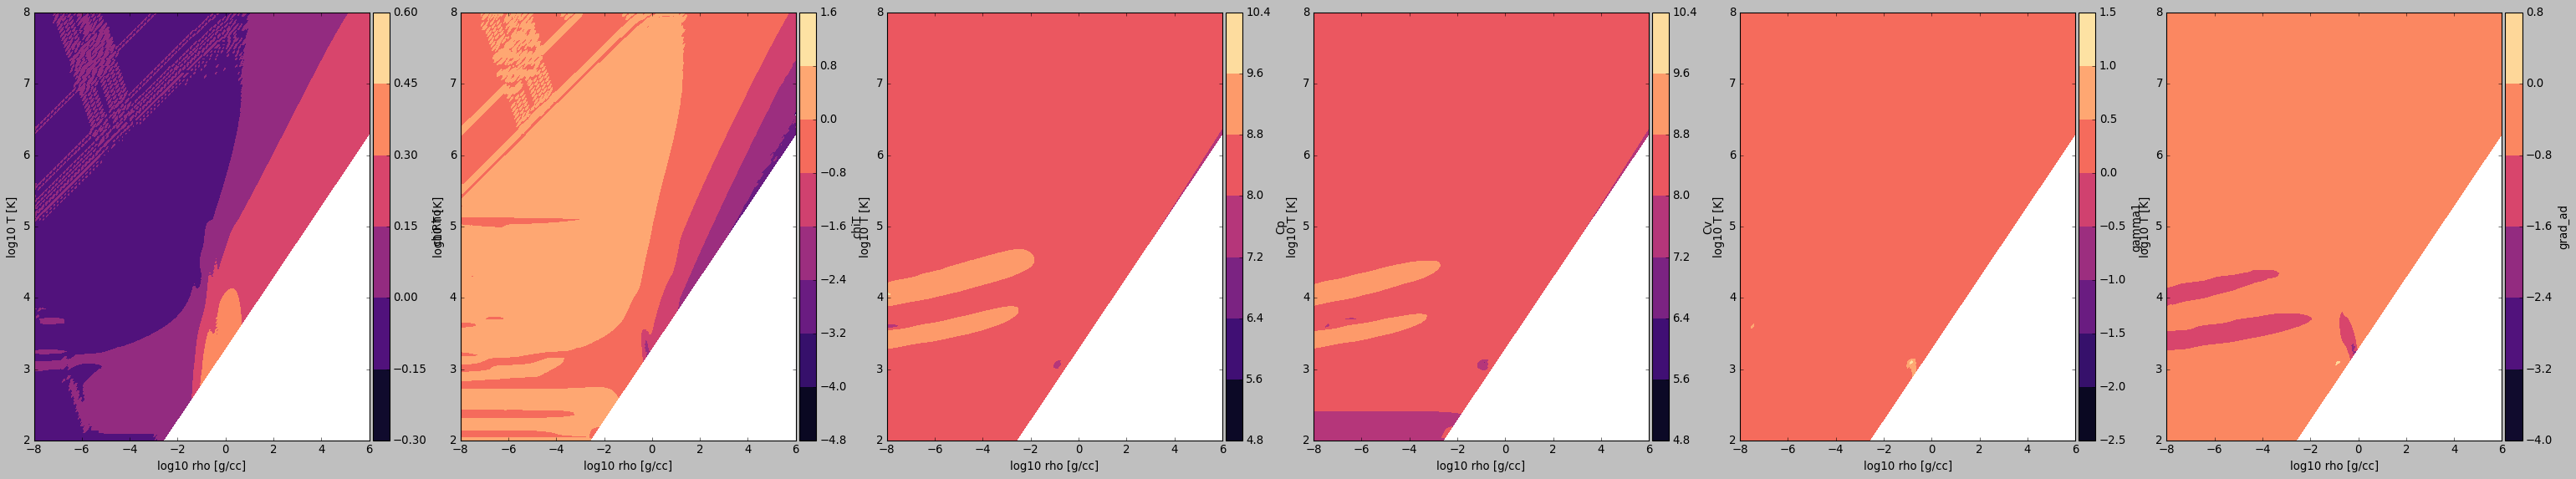

In [8]:
plot_problematic_columns(MESAtable=z00x100)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: invalid value encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)


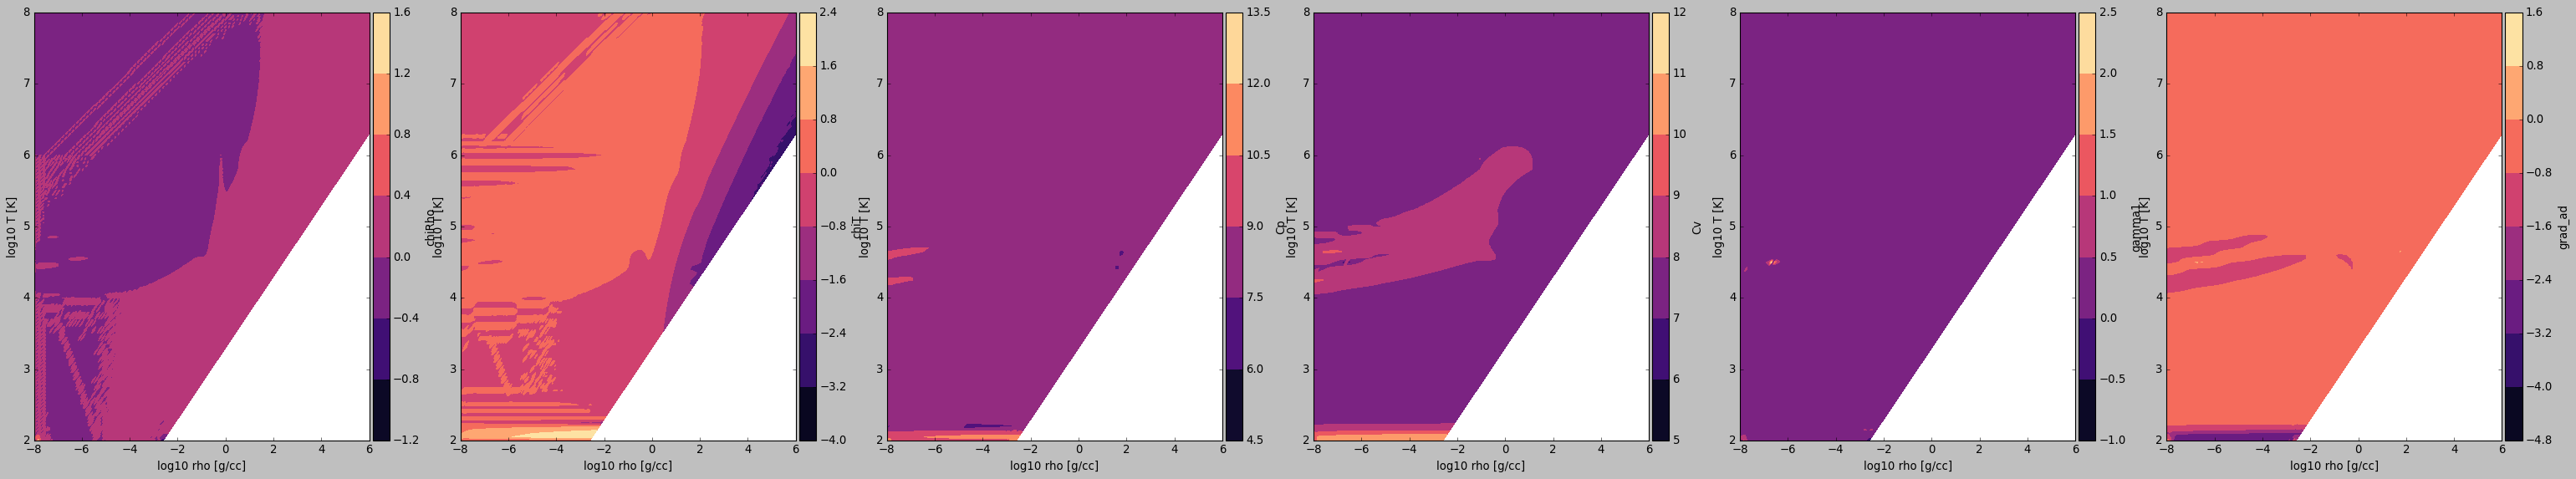

In [9]:
plot_problematic_columns(MESAtable=z00x00)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: invalid value encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)


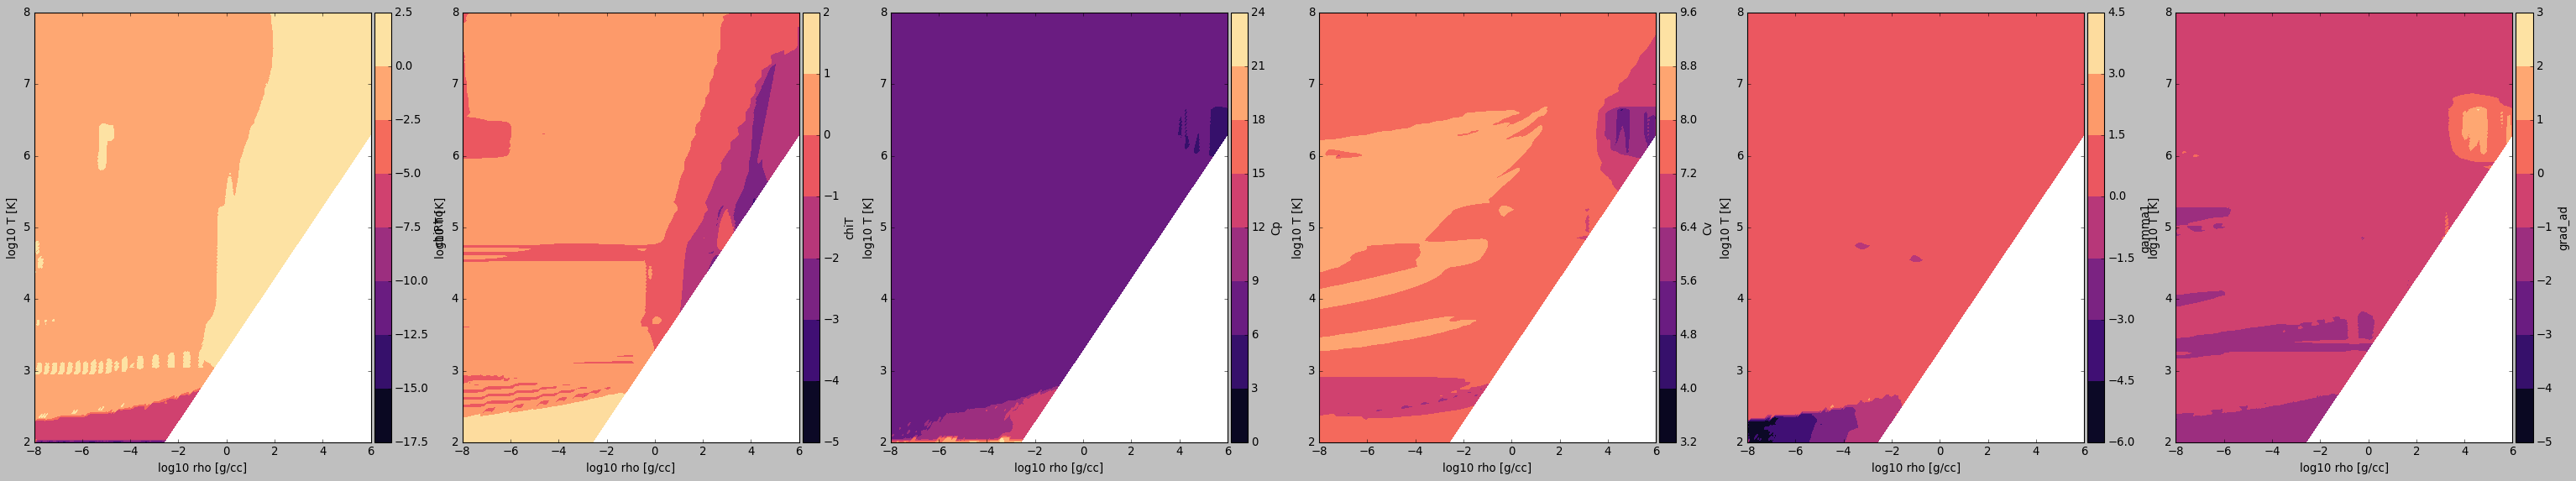

In [10]:
plot_problematic_columns(MESAtable=z100x00)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: invalid value encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: divide by zero encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)


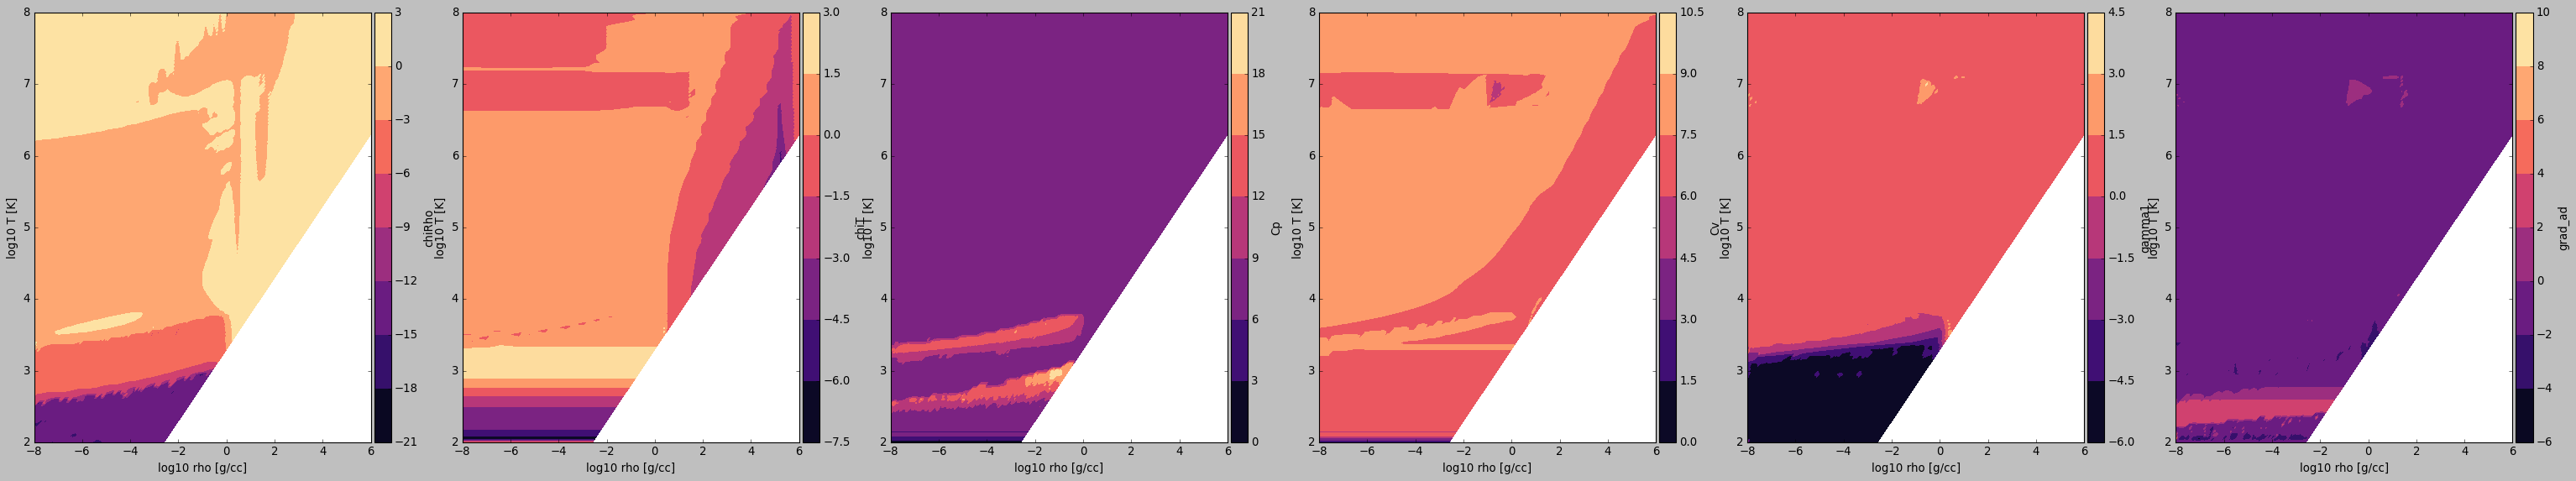

In [11]:
plot_problematic_columns(MESAtable=rock)

/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: invalid value encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)
/var/folders/vr/5jyx18rn3vb6ccm0db12sp8w0000gn/T/ipykernel_80775/1164861030.py:13: RuntimeWarning: divide by zero encountered in log10
  cs = axes[i].contourf(MESAtable[:,:,18], MESAtable[:,:,0], np.log10(MESAtable[:,:,pc]), cmap='magma',alpha=1)


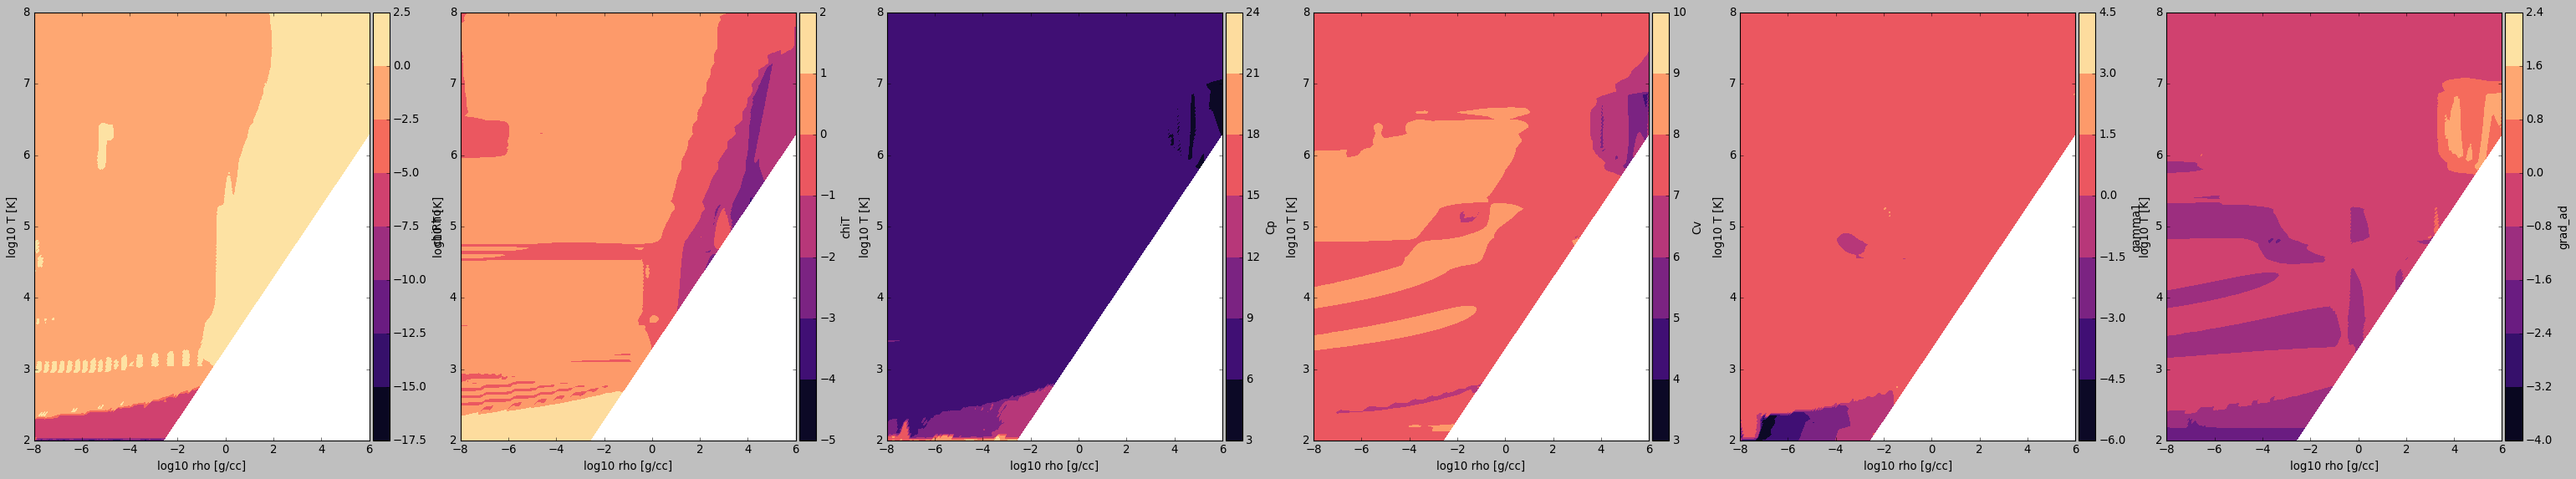

In [12]:
plot_problematic_columns(MESAtable=h2o)